# Unsupervised learning

## Data

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,4)
#plt.style.use('fivethirtyeight')

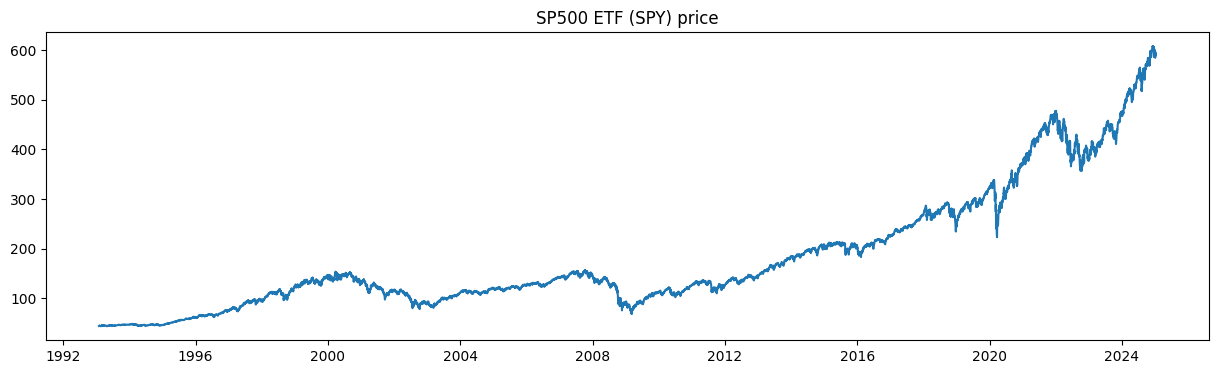

In [3]:
# Get data
data = pd.read_excel('spy.xlsx', index_col=0, parse_dates=True)
plt.title('SP500 ETF (SPY) price')
plt.plot(data['Close'])
plt.show()

## Create features

In [ ]:
# Volatili df[['H-L'ty measure, taking into account any gaps in the price movement
def ATR(dataframe, period):
    'function to calculate True Range and Average True Range'
    df = dataframe.copy()
    df['H-L']  = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Close'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Close'].shift(1))
    df['TR']   =,'H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR']  = df['TR'].rolling(period).mean()
    df = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df['ATR']

In [5]:
# Feature creation
data['ATR'] = ATR(data, 20)
data['Svolume'] = data['Volume'] / data['Volume'].rolling(20).mean()
data['Range'] = (data['High'] - data['Low']) / data['ATR']

# Calculate open-to-open returns
data['Return'] = (data.Open.shift(-2) - data.Open.shift(-1))/data.Open.shift(-1)
data['Daily Return'] = data['Close'].pct_change()

# Cluster value set up to 0 for now
data['Cluster'] = 0

# Show dataset
data = data.dropna()
data.tail()

,Open,High,Low,Close,Adj Close,Volume,ATR,Svolume,Range,Return,Daily Return,Cluster
Date,,,,,,,,,,,,
2024-12-30,587.890015,591.739990,584.409973,588.219971,588.219971,56578800,6.132001,1.128795,1.195371,-0.000881,-0.011412,0
2024-12-31,589.909973,590.640015,584.419983,586.080017,586.080017,57052700,6.350500,1.110222,0.979455,-0.003156,-0.003638,0
2025-01-02,589.390015,591.130005,580.500000,584.640015,584.640015,50204000,6.791003,0.955295,1.565307,0.014876,-0.002457,0
2025-01-03,587.530029,592.599976,586.429993,591.950012,591.950012,37888500,6.989001,0.724328,0.882813,0.001929,0.012503,0
2025-01-06,596.270020,599.700012,593.599976,595.359985,595.359985,47679400,7.267502,0.895315,0.839358,-0.014596,0.005761,0


In [6]:
# Split the data from 2020 onwards
df_train = data[data.index <= datetime(2020,1,1)]
df_test  = data[data.index > datetime(2020,1,1)]
# Define train and test with two features
X_train = df_train[['Svolume', 'Range']]
X_test = df_test[['Svolume', 'Range']]
X_test.tail()

,Svolume,Range
Date,,
2024-12-30,1.128795,1.195371
2024-12-31,1.110222,0.979455
2025-01-02,0.955295,1.565307
2025-01-03,0.724328,0.882813
2025-01-06,0.895315,0.839358


## Find the optimal number of clusters

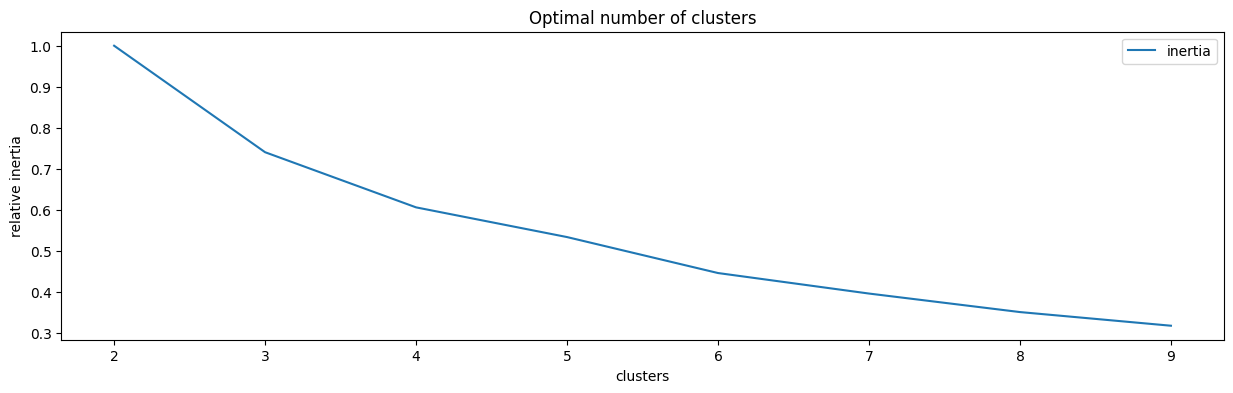

In [9]:
n_clusters = range(2, 10)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train)
    #kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, np.divide(inertia,inertia[0]))
#plt.hlines(0.1, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
#plt.hlines(0.05, n_clusters[0], n_clusters[-1], 'r', linestyles='dashed')
plt.title('Optimal number of clusters')
plt.xlabel('clusters')
plt.ylabel('relative inertia')
plt.legend(['inertia', '10% relative inertia', '5% relative inertia']);

### Training

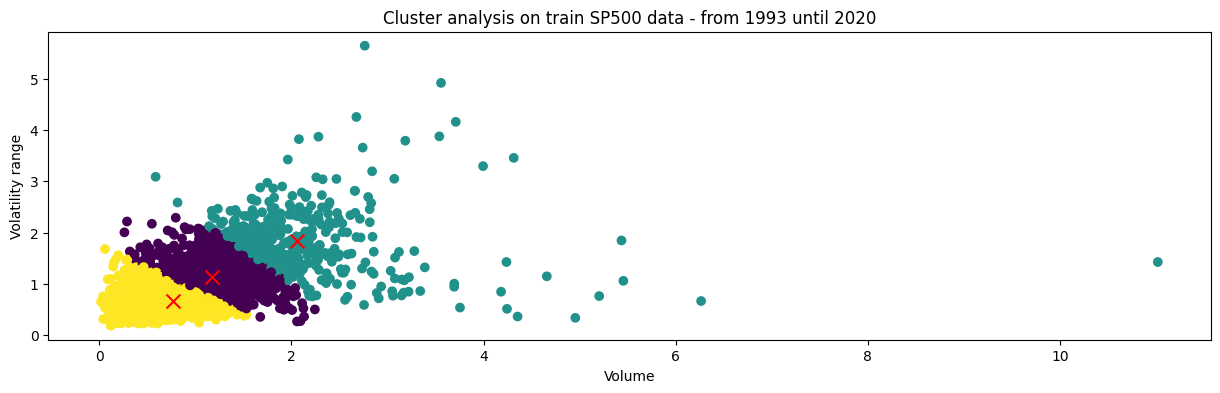

In [11]:
# Training with 3 clusters
kmeans = KMeans(n_clusters=3).fit(X_train)
df_train['Cluster']  = kmeans.predict(X_train)
# Train plot
centers = kmeans.cluster_centers_
plt.scatter(X_train['Svolume'], X_train['Range'], c=df_train['Cluster'])
plt.scatter(centers[:,0], centers[:,1], c='red', s=100, marker='x')
plt.xlabel('Volume')
plt.ylabel('Volatility range')
plt.title('Cluster analysis on train SP500 data - from 1993 until 2020')
plt.show()

### Testing

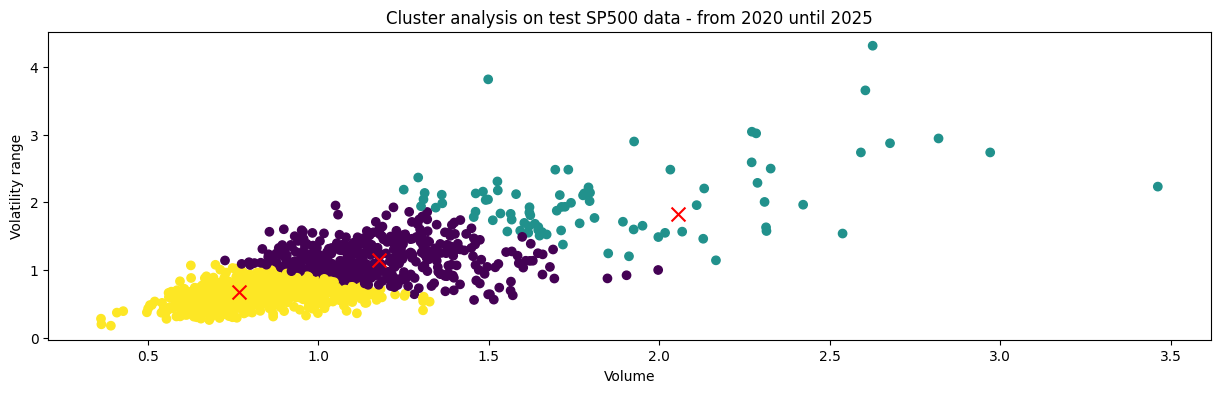

In [12]:
# Testing : Assign to df_train dataframe
df_test['Cluster']  = kmeans.predict(X_test)
# Test plot
centers = kmeans.cluster_centers_
plt.scatter(X_test['Svolume'], X_test['Range'], c=df_test['Cluster'])
plt.scatter(centers[:,0],centers[:,1], c='red', s=100, marker='x')
plt.xlabel('Volume')
plt.ylabel('Volatility range')
plt.title('Cluster analysis on test SP500 data - from 2020 until 2025')
plt.show()

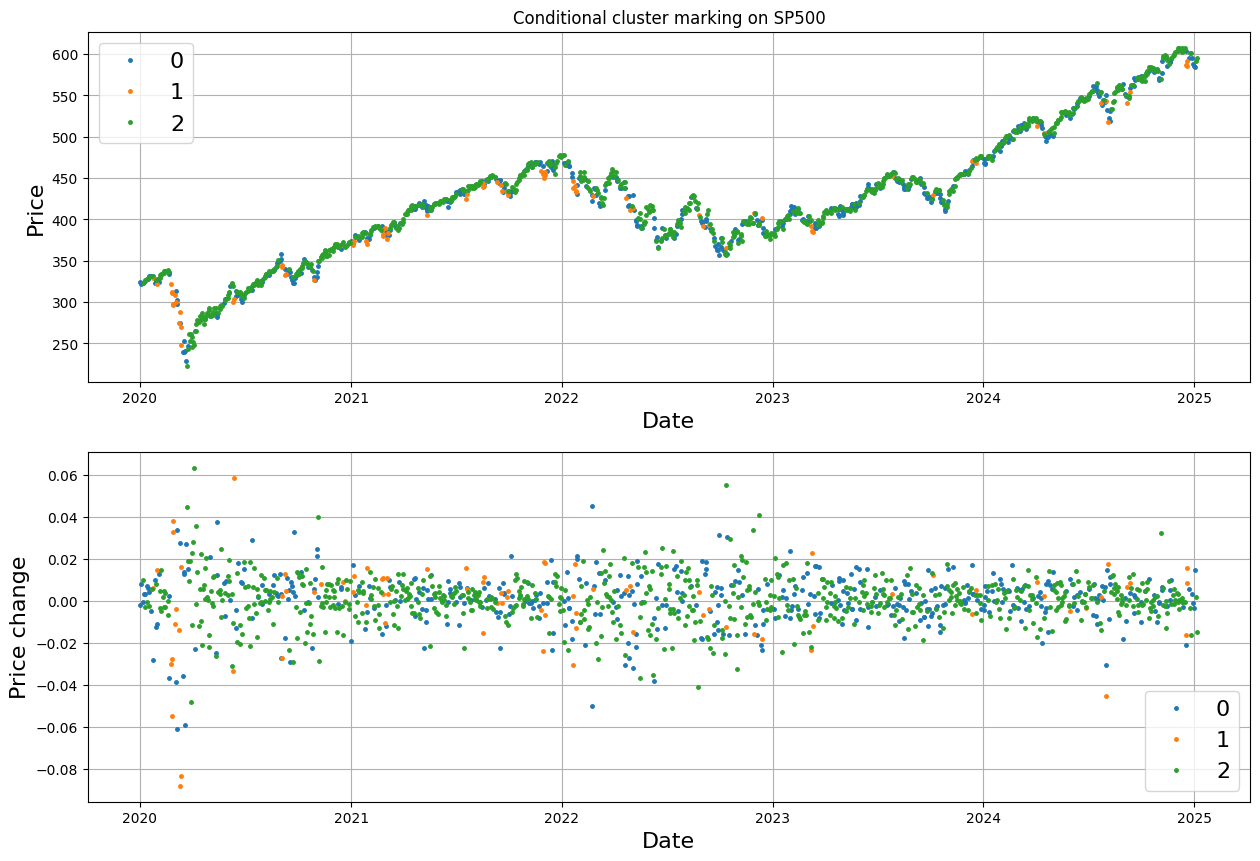

In [21]:
#Plot
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.title('Conditional cluster marking on SP500')
states = [0,1,2]
for i in states:
    want = (df_test['Cluster'] == i)
    x = df_test.index[want]
    y = df_test['Close'].loc[want]
    plt.plot(x, y, '.', ms=5)
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Price", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (df_test['Cluster'] == i)
    x = df_test.index[want]
    y = df_test['Return'].loc[want]
    plt.plot(x, y, '.', ms=5)
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Price change", fontsize=16)
plt.show()

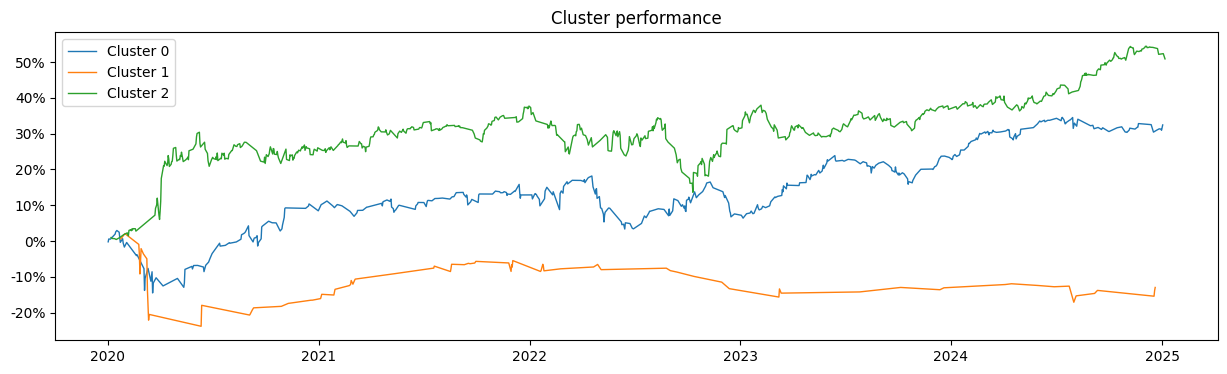

In [14]:
# Performance plot
plt.plot(np.cumsum(df_test['Return'].loc[df_test['Cluster'] == 0]),label='Cluster 0', lw=1)
plt.plot(np.cumsum(df_test['Return'].loc[df_test['Cluster'] == 1]),label='Cluster 1', lw=1)
plt.plot(np.cumsum(df_test['Return'].loc[df_test['Cluster'] == 2]),label='Cluster 2', lw=1)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.title('Cluster performance')
plt.legend()
plt.show()

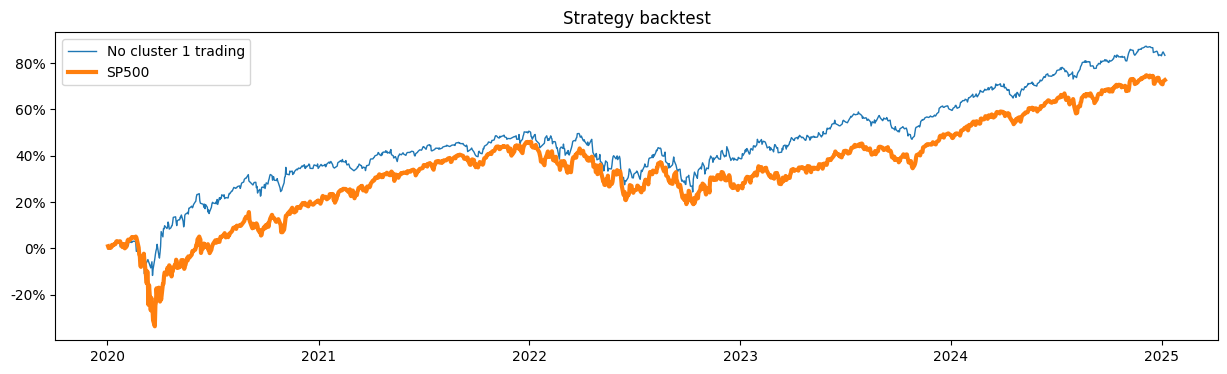

In [20]:
plt.plot(np.cumsum(df_test['Return'].loc[df_test['Cluster'] != 1]),label='No cluster 1 trading', lw=1)
plt.plot(np.cumsum(df_test['Daily Return']), lw=3, label='SP500')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.title('Strategy backtest')
plt.legend()
plt.show()